In [18]:
from google.colab import drive
drive.mount('/content/drive')
# setup working directory to a folder in Google Drive
import os 
root_dir = "/content/drive/My Drive/"
# set folder name (this folder should exist in 'root_dir')
project_folder = "multisensory_data/"

def set_working_directory(project_folder):
  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

set_working_directory(project_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Your working directory was changed to /content/drive/My Drive/multisensory_data/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [2]:
# install pymeanshift
! git clone https://github.com/fjean/pymeanshift.git

fatal: destination path 'pymeanshift' already exists and is not an empty directory.


In [1]:
%cd pymeanshift 
! python setup.py install

[Errno 2] No such file or directory: 'pymeanshift'
/content
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [2]:
import sys, os
sys.path.append(os.getcwd())

In [3]:
import pymeanshift as pms
from pymeanshift import segment

In [5]:
%cd ..

/


In [4]:
import cv2
import numpy as np
from PIL import Image
from io import StringIO
import PIL.Image
from matplotlib import cm
import re
from matplotlib import pyplot as plt
import pathlib
from pathlib import Path 
import PIL
import pandas as pd

In [6]:
def graythresh(array,level):
    '''array: is the numpy array waiting for processing
    return thresh: is the result got by OTSU algorithm
    if the threshold is less than level, then set the level as the threshold
    by Xiaojiang Li
    '''
    
    maxVal = np.max(array)
    minVal = np.min(array)
    
#   if the inputImage is a float of double dataset then we transform the data 
#   in to byte and range from [0 255]
    if maxVal <= 1:
        array = array*255
        # print "New max value is %s" %(np.max(array))
    elif maxVal >= 256:
        array = np.int((array - minVal)/(maxVal - minVal))
        # print "New min value is %s" %(np.min(array))
    
    # turn the negative to natural number
    negIdx = np.where(array < 0)
    array[negIdx] = 0
    
    # calculate the hist of 'array'
    dims = np.shape(array)
    hist = np.histogram(array,range(257))
    P_hist = hist[0]*1.0/np.sum(hist[0])
    
    omega = P_hist.cumsum()
    
    temp = np.arange(256)
    mu = P_hist*(temp+1)
    mu = mu.cumsum()
    
    n = len(mu)
    mu_t = mu[n-1]
    
    sigma_b_squared = (mu_t*omega - mu)**2/(omega*(1-omega))
    
    # try to found if all sigma_b squrered are NaN or Infinity
    indInf = np.where(sigma_b_squared == np.inf)
    
    CIN = 0
    if len(indInf[0])>0:
        CIN = len(indInf[0])
    
    maxval = np.max(sigma_b_squared)
    
    IsAllInf = CIN == 256
    if IsAllInf !=1:
        index = np.where(sigma_b_squared==maxval)
        idx = np.mean(index)
        threshold = (idx - 1)/255.0
    else:
        threshold = level
    
    if np.isnan(threshold):
        threshold = level
    
    return threshold


In [7]:
def VegetationClassification(Img):
    '''
    This function is used to classify the green vegetation from GSV image,
    This is based on object based and otsu automatically thresholding method
    The season of GSV images were also considered in this function
        Img: the numpy array image, eg. Img = np.array(Image.open(StringIO(response.content)))
        return the percentage of the green vegetation pixels in the GSV image
    
    By Xiaojiang Li
    '''
    
    # use the meanshift segmentation algorithm to segment the original GSV image
    (segmented_image, labels_image, number_regions) = pms.segment(Img,spatial_radius=40,
                                                     range_radius=1, min_density=40)
    
    I = segmented_image/255.0
    
    red = I[:,:,0]
    green = I[:,:,1]
    blue = I[:,:,2]
    
    # calculate the difference between green band with other two bands
    green_red_Diff = green - red
    green_blue_Diff = green - blue
    
    ExG = green_red_Diff + green_blue_Diff
    diffImg = green_red_Diff*green_blue_Diff
    
    redThreImgU = red < 0.6
    greenThreImgU = green < 0.9
    blueThreImgU = blue < 0.6
    
    shadowRedU = red < 0.3
    shadowGreenU = green < 0.3
    shadowBlueU = blue < 0.3
    del red, blue, green, I
    
    greenImg1 = redThreImgU * blueThreImgU*greenThreImgU
    greenImgShadow1 = shadowRedU*shadowGreenU*shadowBlueU
    del redThreImgU, greenThreImgU, blueThreImgU
    del shadowRedU, shadowGreenU, shadowBlueU
    
    greenImg3 = diffImg > 0.0
    greenImg4 = green_red_Diff > 0
    threshold = graythresh(ExG, 0.1)
    
    if threshold > 0.1:
        threshold = 0.1
    elif threshold < 0.05:
        threshold = 0.05
    
    greenImg2 = ExG > threshold
    greenImgShadow2 = ExG > 0.05
    greenImg = greenImg1*greenImg2 + greenImgShadow2*greenImgShadow1
    del ExG,green_blue_Diff,green_red_Diff
    del greenImgShadow1,greenImgShadow2
    del greenImg1,greenImg2
    del greenImg3,greenImg4
    
    return greenImg

In [8]:
# make folder to save greeness images
! mrdir green_segmentation

/bin/bash: mrdir: command not found


In [45]:
img = Image.open('101.jpeg')
img = img.resize((538, 269))

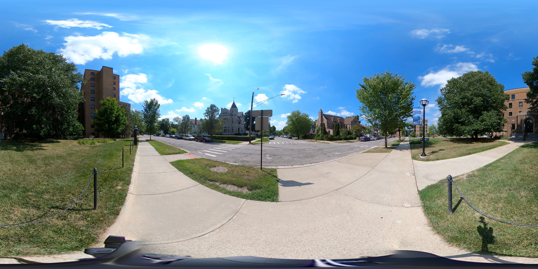

In [46]:
img

In [47]:
np.seterr(invalid='ignore')
greenimg = VegetationClassification(img)

In [48]:
PxlNum = len(np.where(greenimg != 0)[0])
totalPxl = len(greenimg[0])*len(greenimg)
green_per = PxlNum/totalPxl*100
segimg = Image.fromarray(np.uint8(cm.gist_earth(greenimg)*225))
# save_n = Path(i).stem + f'.png'
# save_dir = save_p(save_n)
# segimg.save(save_dir)

In [53]:
green_per

28.86361437791075

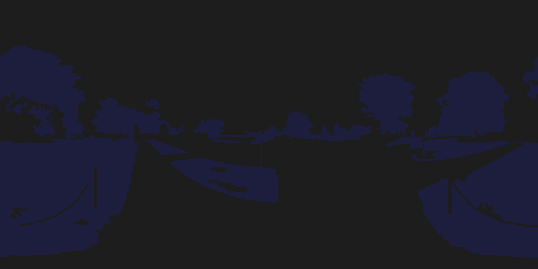

In [52]:
segimg